# Micro-Level Indicators and Machine Learning as an Early Warning Signal Tool: Predicting Loan Defaults with Support Vector Model vs Logistic Regression


Prepared by: Jessica P. Hutalla
           

*This Capstone is undertaken in compliance with the Postgraduate Course on Artificial Intelligence and Machine Learning at AIM-Emeritus.*

**I. INTRODUCTION**

The global financial system has changed significantly, affecting countries and individuals alike. These changes bring new risks that could lead to widespread crises, making early monitoring crucial for stability. Traditional macroprudential tools often rely on aggregate indicators and periodic stress tests, which may fail to capture borrower-level vulnerabilities in real time.

This study underscores the importance of micro-level indicators and introduces and compares two machine learning models: Support Vector Machine (SVM) model and Logistic Regression Model, both a supervised learning algorithm used for classification tasks. These models estimate borrower-level default probabilities derived from granular loan-level data—such as credit score, repayment history, collateral value, and loan characteristics.

This study is useful in the monitoring and surveillance during normal times under the Systemic Risk Crisis Management Framework.

**II. OBJECTIVE**

  Modeling Objective:

    a.	Develop and validate an SVM classifier that accurately predicts
        loan default at the borrower level using standard credit
        and collateral features, optimized for surveillance.

    b.  Develop and validate a regularized logistic regression classifier that
        predicts borrower-level loan default using the same standard credit and
        collateral features, optimized for surveillance priorities.

    c.	Compare the results of the two models and recommends which model to
        deploy as early warning indicator during normal times.



**III. RESEARCH QUESTIONS**

    Predictive Performance: How does an SVM-based model perform in predicting
    borrower-level defaults relative to baseline  classifiers (e.g., logistic
    regression), particularly under class imbalance common in credit datasets?

    Moreover, which of the two machinae learning model can effectively
    predict loan default status by leveraging customer financial and
    loan-specific features, thereby providing a robust tool for risk assessment
    in lending decisions?"




**IV. SIGNIFICANCE OF THE STUDY**

    a. Methodological Significance
        Provides a replicable, production-ready approach for borrower-level
        default prediction using SVM and Logistic Regression, incorporating
        best practices in preprocessing, class imbalance handling, and model
        monitoring.

    b. Supervisory Significance
        Bridges micro-level predictions with macroprudential oversight by
        mapping risk scores to systemic indicators used in supervisory
        dashboards and early-warning systems.

    c. Practical Significance
        Offers a framework for normal-times surveillance that can be scaled
        across institutions and loan books, thereby enhancing resilience and
        reducing the likelihood that localized weaknesses snowball into
        system-wide crises.

**V. METHODOLOGY**

Utilizing borrower-level data and variables sourced from Kaggle.com, this study aims to construct predictive models for loan default employing machine learning techniques, specifically Support Vector Machines and Logistic Regression. The implementation will be carried out in Python, and the comparative performance of the models will be systematically evaluated. Based on the results, the study will recommend the most effective algorithm to serve as an early warning indicator for loan default risk. Below are details on the methodology.

Dataset Structure:

Loan_ID, Customer_ID, Loan_Amount, Loan_Type, Credit_Score, Repayment_History, Collateral_Value, Loan_Tenure, Default_Status.
Loan_ID and Customer to be dropped in the model.
Please see Annex A for Data Dictionary.

Target Variable: Default_Status (binary; mapped to {0,1})
                                   – zero represents non-default and one for default
Feature Groups:

    o	Numeric:  Loan_Amount, Credit_Score, Collateral_Value, Loan_Tenure.
               Repayment_History
              

    o	Categorical: Loan_Type (e.g., Business, Education, Home, Personal,
                   and Vehicle)


A. Import necessary libraries to be used in the process.

In [ ]:
# Filename: svm_npl.py
# Python 3.9+ recommended

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



B. Uploading Datasets

    The filename is npa_dataset.csv. Dataset copy is in Annex A.

In [ ]:
from google.colab import files

# 1) Upload file
uploaded = files.upload()  # This opens a file picker in Colab

# If your file is named npa_dataset.csv
import pandas as pd
df = pd.read_csv('npa_dataset.csv')

Saving npa_dataset.csv to npa_dataset.csv


C. Quick Sanity Check

    This is to check the type of data in every column.
    *Please see Annex B for Data Dictionary.*


In [ ]:
# Display column names after cleaning
print("Cleaned Columns:", df.columns.tolist())

Cleaned Columns: ['Loan_ID', 'Customer_ID', 'Loan_Amount', 'Loan_Type', 'Credit_Score', 'Repayment_History', 'Collateral_Value', 'Loan_Tenure', 'Default_Status']


In [ ]:
# Quick sanity check — print columns
print("Columns:", df.columns.tolist())
print(df.head())

Columns: ['Loan_ID', 'Customer_ID', 'Loan_Amount', 'Loan_Type', 'Credit_Score', 'Repayment_History', 'Collateral_Value', 'Loan_Tenure', 'Default_Status']
  Loan_ID Customer_ID  Loan_Amount Loan_Type  Credit_Score  Repayment_History  \
0  L00001      C00001      1742743  Personal           505          68.029548   
1  L00002      C00002      4354572  Business           654          66.635174   
2  L00003      C00003      4976484   Vehicle           330          55.712543   
3  L00004      C00004      2284489   Vehicle           543          70.504439   
4  L00005      C00005      1620006  Business           788          80.254261   

   Collateral_Value  Loan_Tenure  Default_Status  
0            481766           88               1  
1           2912934           33               0  
2           1347431          217               1  
3           2808402          205               1  
4            680588           73               0  


D. Data Cleaning/Target + Features

    Loan_ID and Customer_ID to be dropped in the model.

    Target Variable: Default_Status (binary; mapped to {0,1}) – zero represents
    non-default and one for default

    Feature Groups:

    o	Numeric: Loan_Amount, Credit_Score, Collateral_Value, Loan_Tenure.  Repayment_History

    o	Categorical: Loan_Type (e.g., Business, Education, Home, Personal, and
                          Vehicle)



In [ ]:
# Basic cleaning / target + features
# Drop pure identifiers (not predictive)
drop_cols = ['Loan_ID', 'Customer_ID']

# Define target
target_col = 'Default_Status'   # 0 = performing, 1 = non-performing

# Feature columns (all except target & ID columns)
feature_cols = [c for c in df.columns if c not in drop_cols + [target_col]]

X = df[feature_cols].copy()
y = df[target_col].astype(int)  # ensure integer binary labels

E. Data Quality Handling and Preprocessing Pipeline

    Separate numeric and categorical feature sets.

      o	Missing numeric values imputed with median.
      o	Missing categorical values imputed with the most frequent category.
      o	Class imbalance addressed via class_weight="balanced" and
       threshold calibration.
      o	Cleaning: Normalize column names; drop IDs (Loan_ID, Customer_ID).
      o	Encoding: One-hot encode categorical variables with
        handle_unknown="ignore".
      o	Scaling: Standardize numeric features (StandardScaler) to ensure
        SVM stability.


In [ ]:

# 4) Separate numeric and categorical feature sets -------------------------
numeric_features = ['Loan_Amount', 'Credit_Score', 'Collateral_Value', 'Loan_Tenure', ' Repayment_History ']
categorical_features = ['Loan_Type']

# If unknown categories appear at inference time, handle_unknown='ignore' avoids errors
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # drop other columns
)


F. Train/Test Split with Stratification

    Train-Test Split: Stratified split (e.g., 70/30) to preserve default
                      prevalence.

    The data is split into two main parts:
    1.	X_train, y_train (Training Data): This is the larger portion of the
    data that the machine learning model will learn from. It will look for
    patterns, relationships, and rules within this data.
    2.	X_test, y_test (Testing Data): This is the smaller, separate portion of
    the data that the model has never seen before. After the model is trained,
    this data will be tested see how well it performs on new, unseen examples.
    This gives a more realistic idea of its real-world performance.

    The other component such as random_state=42 and stratify=y are
    described as follows:

    - random_state=42: This is like setting a specific seed for a random number
    generator. If this code is run multiple times with random_state=42, it will
    always get the exact same split of data. This is important for
    reproducibility to be able t0 get the same results every time the code is
    run.

	  - stratify=y: This is where "stratification" comes in, and this is
        particularly important when the target variable (y) has an imbalanced
        distribution
       (e.g., many more '0's than '1's in Default_Status).

        o	If stratify is not used, the split might accidentally put almost
            all the '1's (defaults) into the training set and very few into the
            test set, or vice-versa. This would make the model's evaluation
            unreliable.

        o	By setting stratify=y, the train_test_split function interprets:
           "Make sure that the proportion of '0's and '1's in y_train is
            roughly the same as the proportion of '0's and '1's in y_test. Also,
            make sure these proportions are similar to the original y dataset."
            This ensures both the training and testing sets are representative
            of the overall data distribution of the target variable.

            Please see below the train/test code:



In [ ]:
# Train/test split with stratification ----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

G. Modeling: Support Vector Machine (SVM)

      1. Build SVM Pipeline:

      The pipeline is like an assembly line for the data. It links together
      several steps undertaken above that the data needs to go through,
      ensuring they happen in the correct order every time. This is super handy
      because it keeps the code clean and prevents mistakes.

        •	('prep', preprocess): This is the first station on the assembly
             line. It takes all the preprocessing steps defined earlier (like
             handling missing values, scaling numbers, and one-hot encoding
             categories) and applies them to the raw data.

      2. Classifier: SVC(probability=True, class_weight="balanced", kernel
         in {linear, rbf}).

         This is the second and final station. After the data has been cleaned
         and transformed by preprocess, it then feeds that prepared data directly
         into the svm_clf model for training or prediction.

          - svm_clf: This is the Support Vector Classifier (SVC), a powerful
          type of machine learning model often used for classification tasks
          (like predicting 0 or 1).

          - kernel='rbf': Think is a more complex boundary to separate the
          categories.
          
            'rbf' (Radial Basis Function) is a common choice that allows
            the SVM to find non-linear boundaries. It means the model isn't
            just drawing straight lines; it can find curved or complex shapes
            to separate - the 'default' from 'non-default' loans.

          - probability=True: By default, an SVC just tells if it thinks a loan
            will default or not (0 or 1). Setting probability=True makes it
            also tell how confident it is in that prediction (e.g., 80% sure
            that the loan will default). This is useful for evaluating the
            model and making business decisions.

          - class_weight='balanced': This is very important for the
            Default_Status prediction. If there are many more 'non-default'
            loans (0s) than 'default' loans (1s), the model might just learn to
            always predict '0' because it's the most common answer.
            class_weight='balanced' tells the SVM to pay extra attention to the
            rarer 'default' cases so it doesn't ignore them, ensuring it learns
            from both types of outcomes fairly. It prevents the model from
            being biased towards the majority class.

      In essence, this step of the process is like building a complete system
      that first cleans and prepares the data correctly, and then feeds it
      directly into your powerful SVM model, all in one smooth, repeatable
      process.

      Please see below the codes for the SVM Classifier.


In [ ]:
# Build SVM pipeline -----------------------------------------------------
# class_weight='balanced' helps when defaults (1s) are rarer than non-defaults (0s)
svm_clf = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('svm', svm_clf)
])

      3. Hyperparameter Tuning via Cross-Validation

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Added this import
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Added StandardScaler
from sklearn.compose import ColumnTransformer # Added this import

# 7) Hyperparameter tuning via cross-validation ----------------------------

# Correct the numeric_features list by removing leading/trailing spaces
numeric_features = ['Loan_Amount', 'Credit_Score', 'Collateral_Value', 'Loan_Tenure', 'Repayment_History']

# Re-define preprocess with the corrected numeric_features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # drop other columns
)

# Re-define pipe with the corrected preprocess
svm_clf = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('svm', svm_clf)
])

param_grid = {
    'svm__C': [1, 2],          # margin hardness
    'svm__gamma': ['scale', 0.1] # RBF kernel width
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',     # use ROC-AUC for imbalanced binary classification
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\nBest params:", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))

best_model = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Param_grid above is like a menu of different settings for the model to see which commbination works best. It is analogous to a complex machine with adjustable knobs or settings.

The following settings used in this project are the following:

1. svm_c: [1, 2]

   The small c value hardness is set at 1 and 2 only in consideration of the capacity of the device used to run the codes. The program crashed several times with more than two c values.

   This C represents the margin hardness. This knob controls how strict the SVM model is when drawing the dividing line between 'default' and 'non-default' loans. I chose 1 and 2 as these represent average strictness instead of having a small c value of 0.5 which means the model is forgiving and allows some misclassifications, although having a small c can help prevem overfitting. Meanwhile, having a large c value represents strict classification and may potentially perform poorly on new unseen data.

2. svm_gamma: ['scale', 0.1]

    The gamma value is set at scale and 0.1 only in consideration of the capacity of the device used to run the codes. The program
    crashed several times with more than two gamma values.

    The gamma or RBF kernel width is specific to the rbf kernel (the 'curvy' way the model divides the data). It controls how far the influence of a single training example reaches when the model decides where to draw its boundaries.

    For this project, the 'scale' is used as this is the default setting and often a good starting point. It automatically calculates a reasonable gamma value based the data.

    The a large gamma value was also chosen like 0.1. This means that training examples have a short influence. The model will be very sensitive to individual data points, leading to a very wiggly boundary that tries to perfectly fit every little detail in the training data. Although, this may lead to overfitting.

Meanwhile, cv or cross-validation is used to test the model many times to see how consistently well it performs, instead of just one train/test split. The following were utilized:

    •	StratifiedKFold gives a much more stable and reliable measure of the
      model's performance than just one single split. **KFold** split the data
      into K equal folds. Then, you use one fold for testing and the other K-1 fold
      for training. This is repeated K times, making sure each pile gets a turn
      as the test set. Meanwhile, **stratified** prevents a situation where one
      test fold might accidentally have too many or too few defaults, which
      could skew the evaluation. Just like with stratify=y in train_test_split,
      'stratified' means that when the data is split into those K folds, it
      makes sure that each fold has roughly the same proportion of 'default'
      (1s) and 'non-default' (0s) loans as the original dataset.

      I used here •	n_splits=3 instead of 5 due to issues with device capacity: This means K is 3. So, the data will be divided
      into 3 equal parts. The process will run 3 times, for example:

        1.	Test on part 1, train on parts 2,3.
        2.	Test on part 2, train on parts 1,3.
        3.	And so on, until each of the 3 parts has been used as a test set
        exactly once.

      shuffle=True: Before splitting the data into those 3 parts, the data is
      first randomly mixed up. This is important to ensure that if the original
      data had some order (e.g., all the defaults were listed at the end), that
      order doesn't accidentally affect how the parts are formed.


      4. Printing the best model

        Validation: Stratified K-fold (k=5) with grid search; primary metric
        ROC-AUC; secondary metrics F1, Recall, Precision, and PR-AUC (optional).

        (Please see results in PDF version Annex C)

In [ ]:
print("\nBest params:", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))

best_model = grid.best_estimator_

The best fit model was a result when the codes were run. 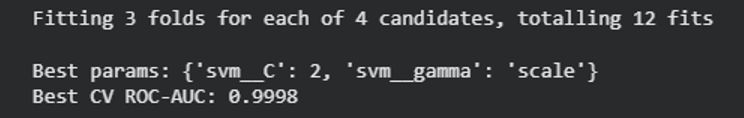It is posted as picture here as it takes too long to run this code again.

5. Evaluation & Diagnostics on Test Sets

    Evaluation of the Test Set

    The performance of the trained model was assessed on the held-out test dataset using both predicted class labels and predicted probabilities. Specifically:

      - Predicted Labels (y_pred) were obtained by applying the model to the test features (X_test).

      - Predicted Probabilities (y_proba) correspond to the likelihood of belonging to the positive class (class = 1), extracted from the model’s probability estimates.

    To comprehensively evaluate classification performance, several standard metrics were computed:

      - Accuracy: Measures the overall proportion of correctly classified instances.

      - Precision: Indicates the proportion of positive predictions that were truly positive, reflecting the model’s ability to avoid false positives.

      - Recall (Sensitivity): Captures the proportion of actual positives correctly identified, highlighting the model’s ability to detect defaults.

      - F1-Score: Represents the harmonic mean of precision and recall, balancing both metrics in scenarios with class imbalance.

      - ROC-AUC: Quantifies the model’s ability to discriminate between classes across all possible thresholds, with higher values indicating stronger separability.

      (Please see results in PDF version)


In [ ]:
# 8) Evaluation on Test Set
# ---------------------------
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # probability of class 1

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)

print("\n=== Test Metrics ===")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1-Score     : {f1:.4f}")
print(f"ROC-AUC      : {roc:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

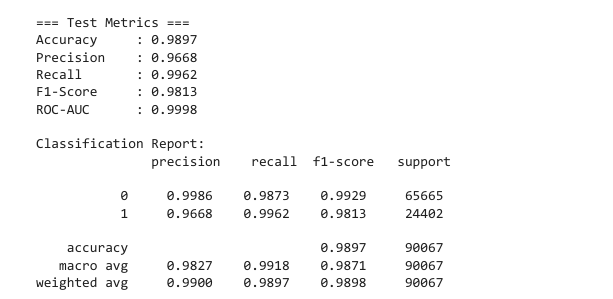

It is posted as picture here as it takes too long to run this code again.

In [ ]:
# 9) Confusion Matrix Plot
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (SVM - Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


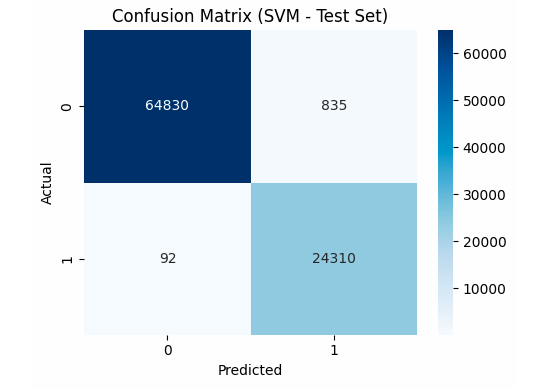

It is posted as picture here as it takes too long to run this code again.

In [ ]:
# 10) ROC Curve Plot
# ---------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


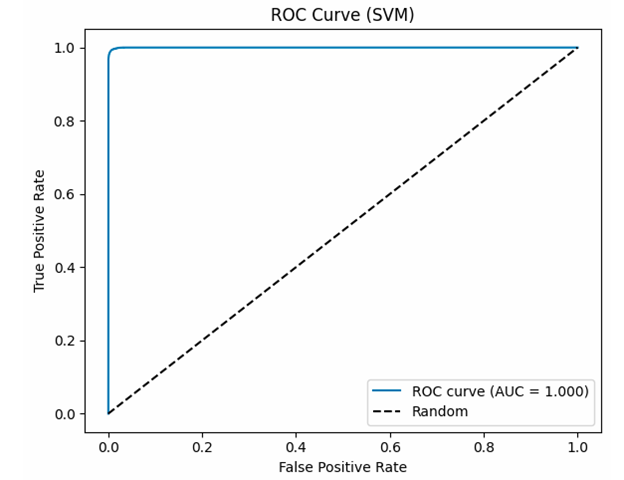

It is posted as picture here as it takes too long to run this code again.

In [ ]:
# 11) Save model
# ---------------------------
model_path = "svm_loan_default_model.pkl"
joblib.dump(best_model, model_path)
print(f"\nModel saved to: {os.path.abspath(model_path)}")

This is to test the saved model with other datasets for the explanatory variables

In [ ]:
# 12) Example: Predict on new data
# ---------------------------
# Build a single-row example with the same columns as X (no IDs, no target)
example = pd.DataFrame([{
    "Loan_Amount": 500000,
    "Loan_Type": "Mortgage",
    "Credit_Score": 690,
    "Repayment_History": "Good",
    "Collateral_Value": 750000,
    "Loan_Tenure": 240
}])

example_pred_proba = best_model.predict_proba(example)[:, 1][0]
example_pred_class = best_model.predict(example)[0]
print(f"\nExample prediction - Probability of default: {example_pred_proba:.4f}, Class: {example_pred_class}")
``

### **TO COMPARE THIS WITH LOGISTIC REGRESSION MODEL**

The following are codes used for the Logistic Regression. Note that the process of cleaning and pipeline constructing are the same except for this part. Results are likewise presented:

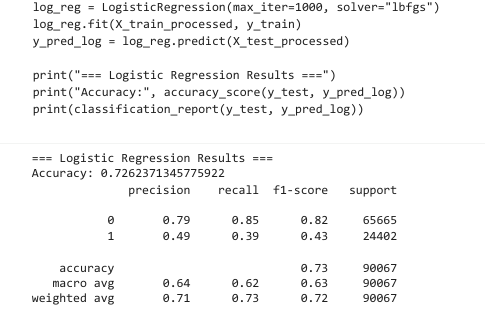



COMPARATIVE RESULTS OF THE TWO MODELS

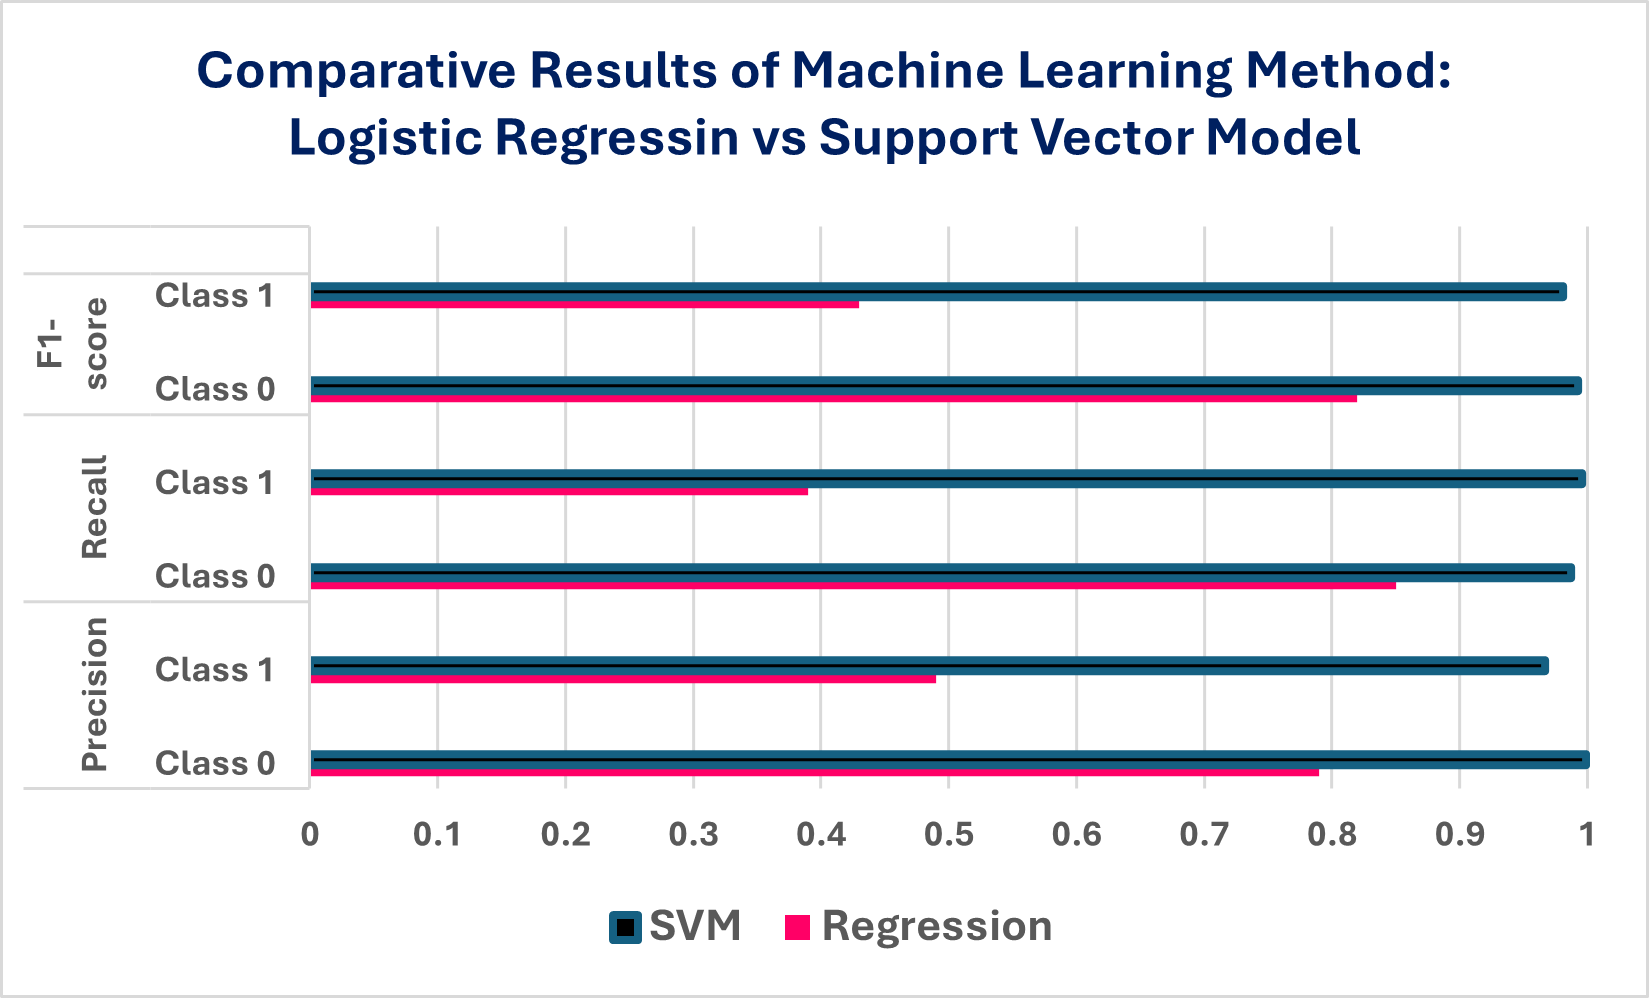

**Comparative Findings**

The comparative evaluation highlights clear differences between Logistic Regression and SVM.

Logistic Regression demonstrates reasonable performance for the majority class (precision 0.79, recall 0.85, F1-score 0.82) but struggles with the minority class (precision 0.49, recall 0.39, F1-score 0.43).

In contrast, the SVM achieves near-perfect results across both classes, with precision, recall, and F1-scores all exceeding 0.96.

This indicates that while Logistic Regression provides a baseline model, the SVM offers substantially stronger predictive capability and balanced performance, making it more effective for loan default detection in both majority and minority borrower groups.

  •	Logistic Regression
    o	Performs reasonably well for the majority class but struggles with the
        minority (defaults).
    o	Precision and recall for default borrowers are relatively low
        (≈0.49 and 0.39), meaning many defaults are missed.
    o	Advantage: simplicity, interpretability, and ease of deployment at
        scale.

  •	Support Vector Machine (SVM)
    o	Achieves near-perfect precision and recall across both majority and
        minority classes (>0.96).
    o	Strong F1-scores indicate balanced performance.
    o	Advantage: highly accurate, robust to imbalance, and reliable in
        capturing rare default events.

  **Recommendation for Early Warning Indicator**

Given the large dataset size (tens of thousands of samples per class) and the critical need to detect minority events (defaults), the SVM model is highly recommended for deployment as the early warning indicator.

  •	Why SVM?

    o	Superior ability to capture minority class defaults without sacrificing
        majority class accuracy.
    o	High recall ensures few defaults are missed — essential for surveillance
        and systemic risk prevention.
    o	High precision reduces false alarms, making monitoring more efficient.

**  Final Recommendation:**

  Deploy the SVM classifier as the primary early warning indicator, supported by Logistic Regression as a benchmark or secondary model for interpretability. This dual setup balances accuracy (SVM) with transparency (Logistic Regression), ensuring robust surveillance during normal times and enhancing systemic risk prevention strategies.

  **Role in Surveillance Tools**

  •	During normal times, the SVM can serve as a continuous monitoring tool, flagging borrowers with elevated default risk.

  •	Its calibrated probability outputs can be integrated into dashboards for risk surveillance, allowing regulators or institutions to track shifts in borrower risk profiles.

  •	By detecting early signals of rising default probabilities, the model supports systemic risk prevention by enabling proactive interventions before defaults accumulate into broader financial instability

